%md

# Cloud Technologies & Big Data Frameworks - BABD GSOM 2024

* ###  Juan David Ocampo
* ###  Sahitya Chaudhary

### Online Retailing II

Dataset source: https://archive.ics.uci.edu/dataset/502/online+retail+ii

This dataset contains the records of a gift shop invoices for the period 01/12/2009 to 09/12/2011, the store is located in the UK but sales worldwide.
the aim of this project is to understand the customer base outside the United Kingdom, which are the main products sold in foreign markets, aswell as top customers, to in the future drive loyalty programs, marketing activities and find possible markets to drive expansion.

Our main objectives are:


* Understand the customer base outside the United Kingdom and find ways to increase the number of sales.
* Identify the product offerings that bring sales inforeign markets.
* Provide actionable insights to enhance customer satisfaction and loyalty



In [0]:
# File location and type
file_location1 = "/FileStore/tables/Online_retail_II_2009_2010.csv"
file_location2 = "/FileStore/tables/Online_retail_II_2010_2011.csv"
file_type = "csv"

# Dataset sourcer https://archive.ics.uci.edu/dataset/502/online+retail+ii
# Dataset was previously preprocessed and splitted into two csv as the original format was a .xlsx file.

from pyspark.sql.types import StructType, StringType, IntegerType, StructField, DoubleType, TimestampType

# Defining the schema beforehand to avoid datatype casting
df_schema = StructType([
  StructField('Invoice', StringType(), True), 
  StructField('StockCode', StringType(), True), 
  StructField('Description', StringType(), True),
  StructField('Quantity', IntegerType(), True), 
  StructField('InvoiceDate', TimestampType(), True), 
  StructField('Price', DoubleType(), True), 
  StructField('Customer ID', StringType(), True), 
  StructField('Country', StringType(), True)
  ])
# The applied options are for CSV files. For other file types, these will be ignored.
df10 = spark.read.csv(file_location1, schema=df_schema, sep=",", header=True)
df11 = spark.read.csv(file_location2, schema=df_schema, sep=",", header=True)

# Creating separate columns for year and month
from pyspark.sql.functions import month, year
df10 = df10.withColumn("Month", month('InvoiceDate'))\
           .withColumn("Year", year('InvoiceDate'))\
           .drop("InvoiceDate")

df11 = df11.withColumn("Month", month('InvoiceDate'))\
           .withColumn("Year", year('InvoiceDate'))\
           .drop("InvoiceDate")


df10.limit(5).display()



Invoice StockCode Description Quantity Price Customer ID Country Month Year 489434 85048 15CM CHRISTMAS GLASS BALL 20 LIGHTS 12 6.95 13085.0 United Kingdom 12 2009 489434 79323P PINK CHERRY LIGHTS 12 6.75 13085.0 United Kingdom 12 2009 489434 79323W WHITE CHERRY LIGHTS 12 6.75 13085.0 United Kingdom 12 2009 489434 22041 "RECORD FRAME 7"" SINGLE SIZE " 48 2.1 13085.0 United Kingdom 12 2009 489434 21232 STRAWBERRY CERAMIC TRINKET BOX 24 1.25 13085.0 United Kingdom 12 2009

There no null values in Quanity or Price, while for customers IDs they account for almost 20% of the dataset, we keep the records as these null values won't interfere with our analysis while the quantity and price still provide usefull information.

In [0]:
# Checking for null values

from pyspark.sql.functions import count, when, col
def count_null(df):
    df.select(*(count(when(col(c).isNull(), c)).alias(c) for c in df.columns)).display()

count_null(df10)
count_null(df11)

Invoice StockCode Description Quantity Price Customer ID Country Month Year 0 0 2928 0 0 107927 0 0 0

Invoice StockCode Description Quantity Price Customer ID Country Month Year 0 0 1454 0 0 135080 0 0 0

<AxesSubplot:>

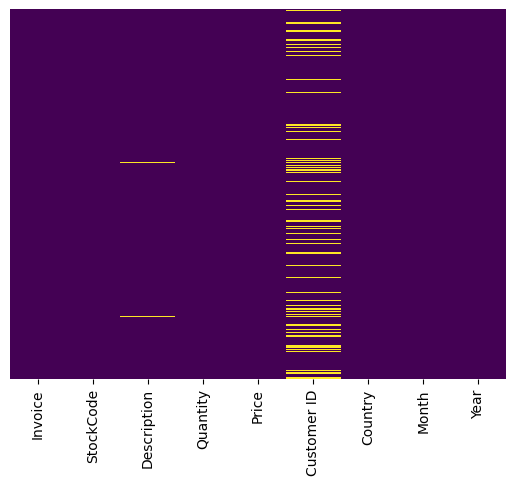

In [0]:
import seaborn as sns
sns.heatmap(data=df10.toPandas().isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [0]:
df10.select("Quantity","Price").summary().display()
df11.select("Quantity","Price").summary().display()

summary Quantity Price count 525461 525461 mean 10.337667305470815 4.6888344786758 stddev 107.42411026879601 146.12691395292634 min -9600 -53594.36 25% 1 1.25 50% 3 2.1 75% 10 4.21 max 19152 25111.09

summary Quantity Price count 541910 541910 mean 9.552233765754462 4.611138332933362 stddev 218.0809569439246 96.75976549366501 min -80995 -11062.06 25% 1 1.25 50% 3 2.08 75% 10 4.13 max 80995 38970.0

%md

As we are only focusing on sales and volume, we are not considering negative values which should be still assesed as they may refer to canceled orders or returns due to damaged goods.

In [0]:
# Truncating the dataframes to only invoices with positive quantities and prices.
df10 = df10.filter((df10.Quantity > 0) & (df10.Price > 0))
df11 = df11.filter((df11.Quantity > 0) & (df11.Price > 0))

In [0]:
from pyspark.sql.functions import udf, round

# Calculating new column with information regarding the total amount for the invoice (Unitary price * Quantity)

def total_invoice(q,p):

    return round(q*p,2)

total_invoice_udf = udf(total_invoice,DoubleType())

df10 = df10.withColumn('Total_invoice', total_invoice(df10['Quantity'],df10['Price']))
df11 = df11.withColumn('Total_invoice', total_invoice(df11['Quantity'],df11['Price']))

In [0]:
from pyspark.sql.functions import sum
df10.select(sum(df10.Total_invoice).alias("total_2010")).display()
df11.select(sum(df11.Total_invoice).alias("total_2011")).display()

total_2010 1.030626558000043E7

total_2011 1.0666702539998397E7

# Analysis


1. Most ordered products
2. Highest invoices in terms of total amount
3. Top customers according to total sales by year
4. top countries by year in term of sales
5. Most growing nation sale-wise
6. Non-UK countries by month to focus on particular sales in that area in that time
7. Top Customers excluding United Kingdom and orders with null Customer ID
8. Most ordered Product sales by month for top 3 countries
9. Number of units sold by month

%md

### 1. Most ordered products

In [0]:
#1. Most ordered products
from pyspark.sql.functions import sum as _sum

top_item_10_total = df10.groupBy("StockCode", "Description") \
    .agg(round(_sum("Quantity"),2).alias("Total_Quantity"), round(_sum("Total_invoice"),2).alias("Total_Sale")) \
    .sort("Total_Quantity",ascending=False)


top_item_11_total = df11.groupBy("StockCode", "Description") \
    .agg(round(_sum("Quantity"),2).alias("Total_Quantity"), round(_sum("Total_invoice"),2).alias("Total_Sale")) \
    .sort("Total_Quantity",ascending=False)

top_item_10_total.display()
top_item_11_total.display()

StockCode Description Total_Quantity Total_Sale 85123A WHITE HANGING HEART T-LIGHT HOLDER 58487 158590.87 84077 WORLD WAR 2 GLIDERS ASSTD DESIGNS 55091 11418.05 17003 BROCADE RING PURSE 48374 8922.8 21212 PACK OF 72 RETRO SPOT CAKE CASES 46755 24069.28 84879 ASSORTED COLOUR BIRD ORNAMENT 45348 73092.99 84991 60 TEATIME FAIRY CAKE CASES 36502 18220.5 21977 PACK OF 60 PINK PAISLEY CAKE CASES 31940 16245.96 85099B JUMBO BAG RED RETROSPOT 30386 54483.87 22197 SMALL POPCORN HOLDER 29788 27034.98 21232 STRAWBERRY CERAMIC TRINKET BOX 27127 34496.68 37410 BLACK AND WHITE PAISLEY FLOWER MUG 25707 3288.65 21213 PACK OF 72 SKULL CAKE CASES 25557 13316.41 21982 PACK OF 12 SUKI TISSUES 25215 8285.21 84568 GIRLS ALPHABET IRON ON PATCHES 24692 5139.58 84755 COLOUR GLASS T-LIGHT HOLDER HANGING 24390 14956.8 84347 ROTATING SILVER ANGELS T-LIGHT HLDR 23049 47985.09 84270 ASSTD DESIGN BUBBLE GUM RING 22996 4836.9 21980 PACK OF 12 RED SPOTTY TISSUES 22723 5982.39 84992 72 SWEETHEART FAIRY CAKE CASES 22078 11029.83 21984 PACK OF 12 PINK PAISLEY TISSUES 22036 5960.1 21981 PACK OF 12 WOODLAND TISSUES 20990 5558.5 15036 ASSORTED COLOURS SILK FAN 20539 14471.71 71459 HANGING JAM JAR T-LIGHT HOLDER 19972 16333.62 85099F JUMBO BAG STRAWBERRY 19851 35918.34 21975 PACK OF 60 DINOSAUR CAKE CASES 19235 9264.04 84598 BOYS ALPHABET IRON ON PATCHES 18824 3814.42 84946 ANTIQUE SILVER TEA GLASS ETCHED 18818 25440.09 20725 LUNCH BAG RED SPOTTY 17943 29866.97 84970S HANGING HEART ZINC T-LIGHT HOLDER 17939 14459.77 22492 MINI PAINT SET VINTAGE 17772 11346.97 85099C JUMBO BAG BAROQUE BLACK WHITE 17327 32200.12 22086 PAPER CHAIN KIT 50'S CHRISTMAS 17226 58189.25 16014 SMALL CHINESE STYLE SCISSOR 17042 5503.64 21985 PACK OF 12 HEARTS DESIGN TISSUES 16905 6295.33 22178 VICTORIAN GLASS HANGING T-LIGHT 16444 20142.52 21915 RED HARMONICA IN BOX 16258 18477.22 21931 JUMBO STORAGE BAG SUKI 15849 31515.16 21731 RED TOADSTOOL LED NIGHT LIGHT 15706 25606.71 21080 SET/20 RED SPOTTY PAPER NAPKINS 15698 12193.89 22411 JUMBO SHOPPER VINTAGE RED PAISLEY 15130 29640.5 21929 JUMBO BAG PINK VINTAGE PAISLEY 14947 27152.96 21088 SET/6 FRUIT SALAD PAPER CUPS 14937 1388.45 20727 LUNCH BAG BLACK SKULL. 14886 24001.28 21096 SET/6 FRUIT SALAD PAPER PLATES 14665 2134.87 84212 "ASSORTED FLOWER COLOUR ""LEIS""" 14486 7031.17 21928 JUMBO BAG SCANDINAVIAN PAISLEY 14307 25941.17 84836 ZINC METAL HEART DECORATION 14307 17378.85 16033 MINI HIGHLIGHTER PENS 14281 1443.72 22386 JUMBO BAG PINK WITH WHITE SPOTS 14213 26264.11 72741 GRAND CHOCOLATECANDLE 14200 19690.13 85099B JUMBO BAG RED WHITE SPOTTY 14071 25065.07 22616 PACK OF 12 LONDON TISSUES 14028 4783.14 21085 SET/6 WOODLAND PAPER CUPS 13732 1873.33 21231 SWEETHEART CERAMIC TRINKET BOX 13704 16989.6 21091 SET/6 WOODLAND PAPER PLATES 13700 1868.7 22423 REGENCY CAKESTAND 3 TIER 13698 170078.51 21790 VINTAGE SNAP CARDS 13414 11579.64 20972 PINK CREAM FELT CRAFT TRINKET BOX 13399 15992.53 21099 SET/6 STRAWBERRY PAPER CUPS 13388 1580.34 21212 PACK OF 72 RETROSPOT CAKE CASES 13386 7668.82 22417 PACK OF 60 SPACEBOY CAKE CASES 13215 6692.35 20728 LUNCH BAG CARS BLUE 13075 21034.11 21092 SET/6 STRAWBERRY PAPER PLATES 12846 1571.5 22151 PLACE SETTING WHITE HEART 12747 5422.56 21498 RED SPOTS WRAP 12700 5126.0 22952 60 CAKE CASES VINTAGE CHRISTMAS 12689 7817.97 22383 LUNCH BAG SUKI DESIGN 12499 20728.49 20726 LUNCH BAG WOODLAND 12408 20626.35 85220 SMALL FAIRY CAKE FRIDGE MAGNETS 12236 6875.0 21704 BAG 250g SWIRLY MARBLES 12160 9308.32 84945 MULTI COLOUR SILVER T-LIGHT HOLDER 12105 9863.17 22585 PACK OF 6 BIRDY GIFT TAGS 12101 15342.28 20719 WOODLAND CHARLOTTE BAG 11637 11527.57 20971 PINK BLUE FELT CRAFT TRINKET BOX 11628 15189.36 22294 HEART FILIGREE DOVE SMALL 11593 14315.69 84970L SINGLE HEART ZINC T-LIGHT HOLDER 11572 11019.22 20724 RED SPOTTY CHARLOTTE BAG 11571 10262.89 84692 BOX OF 24 COCKTAIL PARASOLS 11559 5201.0 85110 BLACK SILVER FLOWER T-LIGHT HOLDER 11520 1138.04 21094 SET/6 RED SPOTTY PAPER PLATES 11403 8790.71 37340 MULTICOLOUR SPRING FLOWER

StockCode Description Total_Quantity Total_Sale 23843 PAPER CRAFT , LITTLE BIRDIE 80995 168469.6 23166 MEDIUM CERAMIC TOP STORAGE JAR 78033 81700.92 84077 WORLD WAR 2 GLIDERS ASSTD DESIGNS 55047 13841.85 85099B JUMBO BAG RED RETROSPOT 48474 94340.05 85123A WHITE HANGING HEART T-LIGHT HOLDER 37599 104340.29 22197 POPCORN HOLDER 36761 34298.87 84879 ASSORTED COLOUR BIRD ORNAMENT 36461 59094.93 21212 PACK OF 72 RETROSPOT CAKE CASES 36419 21259.1 23084 RABBIT NIGHT LIGHT 30788 66964.99 22492 MINI PAINT SET VINTAGE 26633 16937.82 22616 PACK OF 12 LONDON TISSUES 26135 7980.92 21977 PACK OF 60 PINK PAISLEY CAKE CASES 24854 12245.02 22178 VICTORIAN GLASS HANGING T-LIGHT 24304 33187.97 15036 ASSORTED COLOURS SILK FAN 23826 18569.84 17003 BROCADE RING PURSE 23056 6036.39 21915 RED HARMONICA IN BOX 21933 26331.58 22386 JUMBO BAG PINK POLKADOT 21465 42436.24 22197 SMALL POPCORN HOLDER 20160 17055.15 22086 PAPER CHAIN KIT 50'S CHRISTMAS 19355 64952.29 20725 LUNCH BAG RED RETROSPOT 19353 35752.01 47566 PARTY BUNTING 18295 99504.33 84991 60 TEATIME FAIRY CAKE CASES 18214 9183.72 22355 CHARLOTTE BAG SUKI DESIGN 18152 29277.95 22469 HEART OF WICKER SMALL 17971 32107.8 20724 RED RETROSPOT CHARLOTTE BAG 17765 21776.79 85099F JUMBO BAG STRAWBERRY 17273 32570.47 84755 COLOUR GLASS T-LIGHT HOLDER HANGING 16449 10518.25 22961 JAM MAKING SET PRINTED 16412 25660.98 22693 GROW A FLYTRAP OR SUNFLOWER IN TIN 16244 17927.45 22952 60 CAKE CASES VINTAGE CHRISTMAS 16055 9511.52 21213 PACK OF 72 SKULL CAKE CASES 15176 8418.44 22151 PLACE SETTING WHITE HEART 15150 6332.29 23199 JUMBO BAG APPLES 14920 30475.65 84946 ANTIQUE SILVER T-LIGHT GLASS 14688 19411.62 21790 VINTAGE SNAP CARDS 14528 12515.96 22629 SPACEBOY LUNCH BOX 14260 25740.47 21731 RED TOADSTOOL LED NIGHT LIGHT 14009 23932.98 85099C JUMBO BAG BAROQUE BLACK WHITE 13922 28092.2 84568 GIRLS ALPHABET IRON ON PATCHES 13882 2923.13 22423 REGENCY CAKESTAND 3 TIER 13879 174484.74 21931 JUMBO STORAGE BAG SUKI 13654 30770.12 23201 JUMBO BAG ALPHABET 13379 27890.17 84992 72 SWEETHEART FAIRY CAKE CASES 13360 6555.33 16014 SMALL CHINESE STYLE SCISSOR 13328 4335.76 20719 WOODLAND CHARLOTTE BAG 13308 16759.75 21080 SET/20 RED RETROSPOT PAPER NAPKINS 13210 11319.36 20668 DISCO BALL CHRISTMAS DECORATION 12979 1512.92 22993 SET OF 4 PANTRY JELLY MOULDS 12672 16507.23 22411 JUMBO SHOPPER VINTAGE RED PAISLEY 12602 28634.95 22969 HOMEMADE JAM SCENTED CANDLES 12532 18788.55 84978 HANGING HEART JAR T-LIGHT HOLDER 12512 16477.53 22998 TRAVEL CARD WALLET KEEP CALM 12490 5314.9 21975 PACK OF 60 DINOSAUR CAKE CASES 12340 6117.91 21181 PLEASE ONE PERSON METAL SIGN 12305 25290.58 20727 LUNCH BAG BLACK SKULL. 12240 22421.21 23206 LUNCH BAG APPLE DESIGN 12183 20911.98 23307 SET OF 60 PANTRY DESIGN CAKE CASES 12063 6379.59 23310 BUBBLEGUM RING ASSORTED 12050 4997.28 20728 LUNCH BAG CARS BLUE 11817 21750.63 22630 DOLLY GIRL LUNCH BOX 11793 21635.14 21175 GIN + TONIC DIET METAL SIGN 11727 25836.57 21137 BLACK RECORD COVER FRAME 11656 40652.13 22659 LUNCH BOX I LOVE LONDON 11523 20818.7 23203 JUMBO BAG VINTAGE DOILY 11464 24522.36 20713 JUMBO BAG OWLS 11444 23030.96 21929 JUMBO BAG PINK VINTAGE PAISLEY 11007 23181.14 20971 PINK BLUE FELT CRAFT TRINKET BOX 11001 13838.1 23202 JUMBO BAG VINTAGE LEAF 10962 21852.81 71459 HANGING JAM JAR T-LIGHT HOLDER 10792 8560.84 22577 WOODEN HEART CHRISTMAS SCANDINAVIAN 10610 4075.94 22910 PAPER CHAIN KIT VINTAGE CHRISTMAS 10604 32873.34 21326 AGED GLASS SILVER T-LIGHT HOLDER 10583 6890.47 84945 MULTI COLOUR SILVER T-LIGHT HOLDER 10557 8754.63 21498 RED RETROSPOT WRAP 10551 4322.42 22384 LUNCH BAG PINK POLKADOT 10515 17435.19 21232 STRAWBERRY CERAMIC TRINKET BOX 10483 14130.08 22382 LUNCH BAG SPACEBOY DESIGN 10464 18092.36 22578 WOODEN STAR CHRISTMAS SCANDINAVIAN 10462 3877.68 23077 DOUGHNUT LIP GLOSS 10415 13720.77 21166 COOK WITH WINE METAL SIGN 10364 20957.64 22383 LUNCH BAG SUKI DESIGN 10332 18750.58 84212 "ASSORTED FLOWER COLOUR ""LEIS""" 10315 4934.87 79321 CHILLI LIGHTS 10306 54117.76 23344 JU

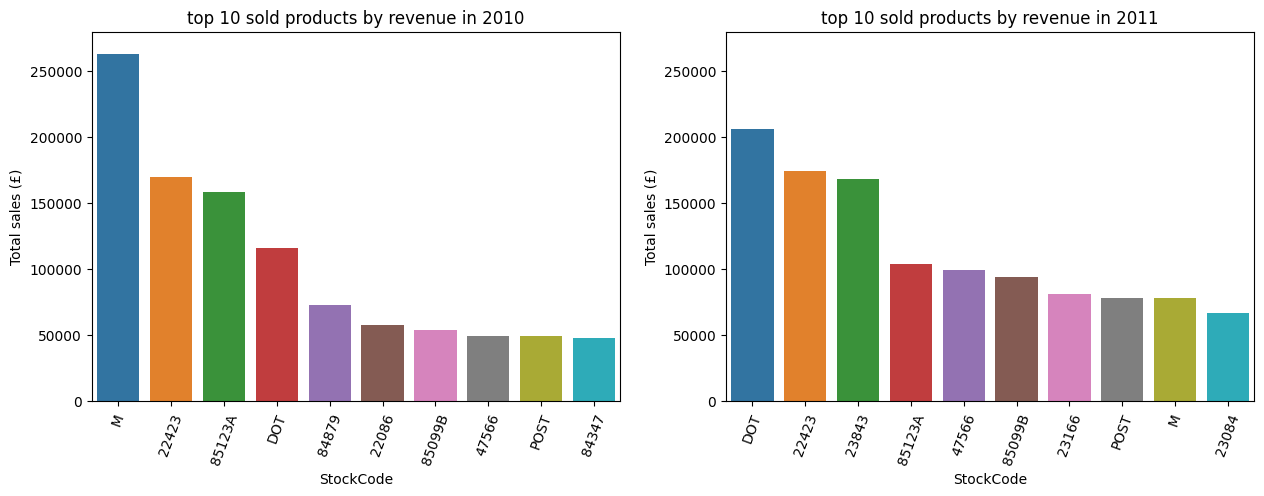

In [0]:
import matplotlib.pyplot as plt
top_sales_10 = top_item_10_total.sort("Total_Sale",ascending=False).limit(10).toPandas()
top_sales_11 = top_item_11_total.sort("Total_Sale",ascending=False).limit(10).toPandas()
fig, ax =plt.subplots(1,2)
sns.barplot(x='StockCode',y="Total_Sale",data=top_sales_10,ax=ax[0]).set(title="top 10 sold products by revenue in 2010",ylabel='Total sales (£)',ylim=(0, 280000))
sns.barplot(x='StockCode',y="Total_Sale",data=top_sales_11,ax=ax[1]).set(title="top 10 sold products by revenue in 2011",ylabel='Total sales (£)',ylim=(0, 280000))

ax[0].tick_params(axis='x', rotation=70)
ax[1].tick_params(axis='x', rotation=70)

fig.set_figwidth(15)


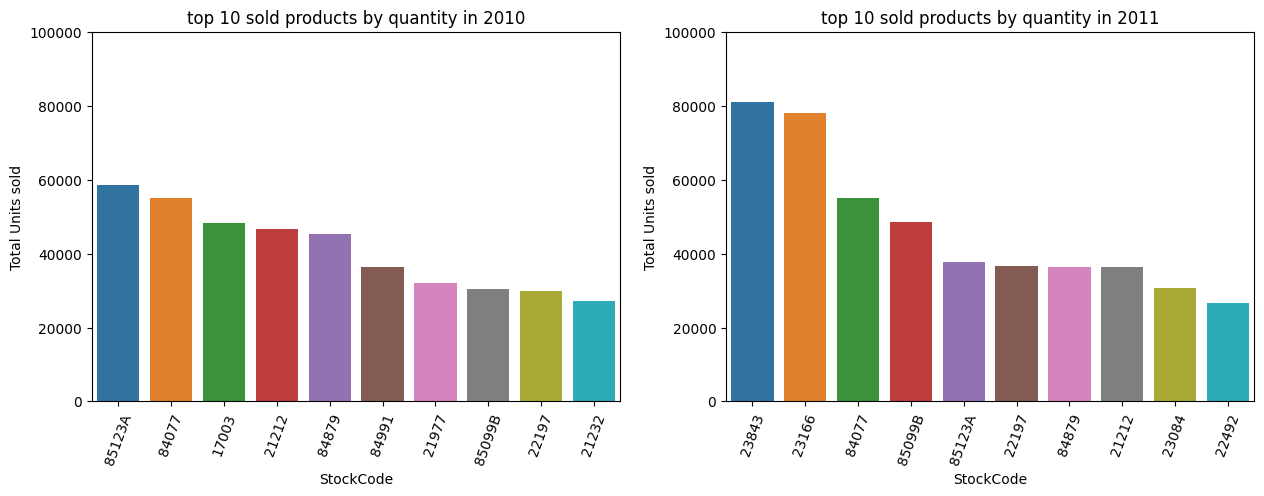

In [0]:
top_sales_10 = top_item_10_total.sort("Total_Quantity",ascending=False).limit(10).toPandas()
top_sales_11 = top_item_11_total.sort("Total_Quantity",ascending=False).limit(10).toPandas()
fig, ax =plt.subplots(1,2)
sns.barplot(x='StockCode',y="Total_Quantity",data=top_sales_10,ax=ax[0]).set(title="top 10 sold products by quantity in 2010",ylabel='Total Units sold',ylim=(0, 100000))
sns.barplot(x='StockCode',y="Total_Quantity",data=top_sales_11,ax=ax[1]).set(title="top 10 sold products by quantity in 2011",ylabel='Total Units sold',ylim=(0, 100000))

ax[0].tick_params(axis='x', rotation=70)
ax[1].tick_params(axis='x', rotation=70)

fig.set_figwidth(15)


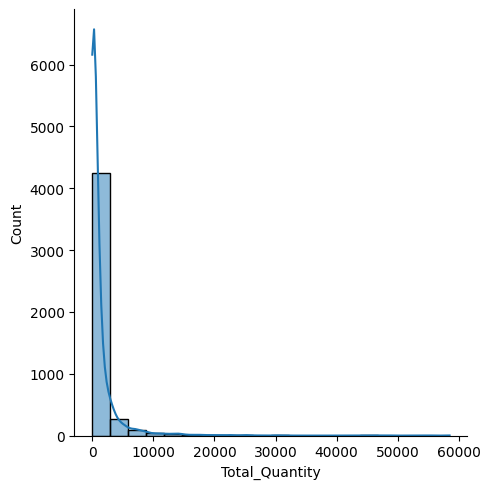

In [0]:
top_item_10_totalqt_pd = top_item_10_total.select("Total_Quantity").toPandas()

sns.displot(top_item_10_totalqt_pd['Total_Quantity'], kde=True, bins = 20)

It don't seem to be a relationship between the most sold articles in the two different years.

%md

### 2. Find the singles invoices with the highest amount sold by year

In [0]:
#2. Highest invoices and customer in terms of total amount

from pyspark.sql.functions import sum as _sum

top_invoices_10 = df10.groupBy("Invoice", "Customer ID","Country") \
                  .agg(round(_sum("Total_invoice"),2).alias("Total_invoice")) \
                  .sort("total_invoice",ascending=False).na.drop()

top_invoices_11 = df11.groupBy("Invoice", "Customer ID", "Country") \
                  .agg(round(_sum("Total_invoice"),2).alias("Total_invoice")) \
                  .sort("total_invoice",ascending=False).na.drop()

top_invoices_10.display()
top_invoices_11.display()

Invoice Customer ID Country Total_invoice 493819 14156.0 EIRE 44051.6 524181 17450.0 United Kingdom 33167.8 526934 18102.0 United Kingdom 26007.08 515944 18102.0 United Kingdom 22863.36 517731 18102.0 United Kingdom 21984.0 495591 14646.0 Netherlands 18570.88 494243 18102.0 United Kingdom 18532.3 531866 18102.0 United Kingdom 18122.17 515187 14156.0 EIRE 17995.88 530715 15838.0 United Kingdom 17022.24 497946 13902.0 Denmark 16973.1 536009 12415.0 Australia 16554.88 518673 14646.0 Netherlands 16483.0 537659 18102.0 United Kingdom 15885.49 535104 16684.0 United Kingdom 15070.22 523921 14646.0 Netherlands 14662.58 527870 16684.0 United Kingdom 14583.78 490059 18102.0 United Kingdom 14475.0 491812 13694.0 United Kingdom 13854.2 513647 14646.0 Netherlands 13330.38 527124 14088.0 United Kingdom 12695.14 507178 14646.0 Netherlands 12569.48 519514 14156.0 EIRE 12513.68 524174 13687.0 United Kingdom 11880.84 518505 14277.0 France 11880.84 533088 12357.0 Switzerland 11229.99 526761 14646.0 Netherlands 11184.3 491456 18102.0 United Kingdom 11016.0 502263 12918.0 United Kingdom 10953.5 509472 18052.0 United Kingdom 10877.18 524159 14063.0 United Kingdom 10468.8 511465 18008.0 United Kingdom 10200.0 502269 17940.0 United Kingdom 10000.0 498395 14646.0 Netherlands 9695.16 537657 18102.0 United Kingdom 9639.12 504436 14156.0 EIRE 9325.28 496115 17949.0 United Kingdom 8985.6 495228 14646.0 Netherlands 8951.24 523929 14646.0 Netherlands 8880.42 530514 14646.0 Netherlands 8661.8 492724 14646.0 Netherlands 8370.08 516781 18102.0 United Kingdom 8328.31 511634 17381.0 United Kingdom 8141.14 512411 14156.0 EIRE 7896.14 499878 14156.0 EIRE 7720.6 533355 14646.0 Netherlands 7611.82 513653 16754.0 United Kingdom 7500.32 497217 14156.0 EIRE 7497.64 530714 16754.0 United Kingdom 7325.68 506467 16754.0 United Kingdom 7210.32 492943 14156.0 EIRE 7112.68 502887 16754.0 United Kingdom 7090.8 495194 13902.0 Denmark 6989.4 501766 15760.0 Norway 6958.17 501768 15760.0 Norway 6958.17 501534 13902.0 Denmark 6866.3 509437 12409.0 Switzerland 6802.48 519640 16684.0 United Kingdom 6785.24 494244 18102.0 United Kingdom 6711.0 504498 17511.0 United Kingdom 6631.27 493885 18102.0 United Kingdom 6624.0 523332 16705.0 United Kingdom 6572.43 507122 12678.0 France 6564.37 498440 18102.0 United Kingdom 6412.0 507235 14298.0 United Kingdom 6361.97 529350 17450.0 United Kingdom 6325.08 508748 17940.0 United Kingdom 6250.0 525968 15838.0 United Kingdom 6082.08 524182 17450.0 United Kingdom 6069.6 503186 18102.0 United Kingdom 6051.45 511335 18102.0 United Kingdom 6007.68 519404 14646.0 Netherlands 5897.68 520948 14646.0 Netherlands 5827.84 509352 18102.0 United Kingdom 5782.0 517817 18087.0 United Kingdom 5737.32 524874 12931.0 United Kingdom 5715.8 499176 16684.0 United Kingdom 5710.32 526585 12931.0 United Kingdom 5698.8 526845 17511.0 United Kingdom 5557.78 500173 18102.0 United Kingdom 5525.28 493994 14091.0 United Kingdom 5520.0 505981 18102.0 United Kingdom 5416.8 532582 15061.0 United Kingdom 5398.24 511109 16684.0 United Kingdom 5368.86 524909 17389.0 United Kingdom 5326.68 531204 17389.0 United Kingdom 5321.16 521315 15838.0 United Kingdom 5293.92 491800 17511.0 United Kingdom 5259.17 526084 16754.0 United Kingdom 5245.18 527145 12409.0 Switzerland 5231.06 497157 18102.0 United Kingdom 5206.5 499297 18102.0 United Kingdom 5158.4 524437 17511.0 United Kingdom 5134.26 508333 13694.0 United Kingdom 5106.73 522513 14156.0 EIRE 5099.44 501049 14646.0 Netherlands 5089.72 521112 14646.0 Netherlands 5023.92 507996 17511.0 United Kingdom 4997.44 489675 13777.0 United Kingdom 4939.22 536324 14646.0 Netherlands 4881.15 502758 14646.0 Netherlands 4865.7 530391 16705.0 United Kingdom 4862.16 522132 18251.0 United Kingdom 4847.52 508096 12931.0 United Kingdom 4815.8 508095 12931.0 United Kingdom 4798.8 507179 14646.0 Netherlands 4751.16 489889 14646.0 Netherlands 4734.24 527113 12454.0 Spain 4733.52 516194 13881.0 United Kingdom 4692.92 525037 14911.0 EIRE 4623.34 503907 18251.0 U

Invoice Customer ID Country Total_invoice 581483 16446.0 United Kingdom 168469.6 541431 12346.0 United Kingdom 77183.6 556444 15098.0 United Kingdom 38970.0 567423 17450.0 United Kingdom 31698.16 556917 12415.0 Australia 22775.93 572209 18102.0 United Kingdom 22206.0 567381 17450.0 United Kingdom 22104.8 563614 12415.0 Australia 21880.44 550461 15749.0 United Kingdom 21535.9 572035 14646.0 Netherlands 20277.92 563076 14646.0 Netherlands 19150.66 562439 12931.0 United Kingdom 18841.48 541220 14156.0 EIRE 16774.72 545475 12415.0 Australia 16726.84 556255 18102.0 United Kingdom 16488.0 537659 18102.0 United Kingdom 15885.49 548011 14646.0 Netherlands 15719.56 569650 12415.0 Australia 15643.77 540815 15749.0 United Kingdom 15160.9 552883 14646.0 Netherlands 14415.74 543989 12415.0 Australia 14022.92 569570 16684.0 United Kingdom 13760.02 561901 14156.0 EIRE 13464.26 558526 17949.0 United Kingdom 13355.4 566934 18102.0 United Kingdom 13249.94 563590 17450.0 United Kingdom 13031.5 540689 17450.0 United Kingdom 12797.52 562789 14646.0 Netherlands 12341.21 544479 14646.0 Netherlands 11956.1 553546 12415.0 Australia 11924.8 547708 17450.0 United Kingdom 11343.2 560445 14156.0 EIRE 11134.34 555920 18102.0 United Kingdom 10999.52 569815 15838.0 United Kingdom 10992.96 581175 14646.0 Netherlands 10901.54 578305 14088.0 United Kingdom 10584.77 541206 14646.0 Netherlands 10389.06 581457 18102.0 United Kingdom 10363.82 561633 17949.0 United Kingdom 10303.95 567280 14646.0 Netherlands 10267.88 558262 14646.0 Netherlands 10174.94 546789 15769.0 United Kingdom 10065.0 537657 18102.0 United Kingdom 9639.12 554366 17450.0 United Kingdom 9468.48 563074 12931.0 United Kingdom 9349.72 552978 12590.0 Germany 9341.26 554827 14646.0 Netherlands 8980.88 580727 14096.0 United Kingdom 8935.98 556726 18102.0 United Kingdom 8915.52 573153 12678.0 France 8895.76 553368 18102.0 United Kingdom 8895.66 560580 14088.0 United Kingdom 8801.51 539731 14646.0 Netherlands 8520.92 576339 14096.0 United Kingdom 8425.54 581105 16000.0 United Kingdom 8345.2 566557 14646.0 Netherlands 8281.12 551697 16029.0 United Kingdom 8142.75 571281 14088.0 United Kingdom 8132.31 575508 14646.0 Netherlands 8111.2 579196 14096.0 United Kingdom 8107.72 541711 14646.0 Netherlands 8060.3 578140 14646.0 Netherlands 7952.68 540818 15749.0 United Kingdom 7837.5 570557 16029.0 United Kingdom 7810.56 558775 18102.0 United Kingdom 7786.0 541570 14646.0 Netherlands 7722.04 570097 16029.0 United Kingdom 7630.56 541789 14088.0 United Kingdom 7544.91 565475 14156.0 EIRE 7480.06 574295 17389.0 United Kingdom 7427.32 572196 18102.0 United Kingdom 7398.54 569343 18102.0 United Kingdom 7298.76 574328 13081.0 United Kingdom 7271.34 561051 16684.0 United Kingdom 7138.12 575219 17511.0 United Kingdom 7059.54 540267 12415.0 Australia 7011.38 578270 14096.0 United Kingdom 6936.52 539101 16029.0 United Kingdom 6930.0 566935 18102.0 United Kingdom 6870.0 561655 18102.0 United Kingdom 6591.6 563563 16029.0 United Kingdom 6578.08 543099 16684.0 United Kingdom 6549.12 564650 14646.0 Netherlands 6429.64 544480 14646.0 Netherlands 6323.38 576374 13777.0 United Kingdom 6260.9 574740 12357.0 Switzerland 6207.67 556415 12409.0 Switzerland 6207.08 574293 17450.0 United Kingdom 6162.62 543379 18102.0 United Kingdom 6155.72 571751 12744.0 Singapore 6068.06 555400 14088.0 United Kingdom 5913.9 569010 14156.0 EIRE 5867.08 543518 12753.0 Japan 5735.24 574294 16333.0 United Kingdom 5727.0 566931 18102.0 United Kingdom 5725.0 557263 14646.0 Netherlands 5683.06 567385 14866.0 United Kingdom 5639.52 565150 14298.0 United Kingdom 5590.67 554845 17450.0 United Kingdom 5518.68 547812 18102.0 United Kingdom 5513.32 574092 16684.0 United Kingdom 5500.38 558776 18102.0 United Kingdom 5496.0 577747 17450.0 United Kingdom 5490.24 560729 17511.0 United Kingdom 5433.57 549027 17857.0 United Kingdom 5424.0 553470 18102.0 United Kingdom 5410.06 557125 17450.0 United Kingdom 5405.48 580665 16684.0 United Kingdom 5401.98 538191 15061.0 Unit

While most of the top invoices come from United Kingdom invoices, some high orders come from key countries like Netherlands, Ireland, Australia

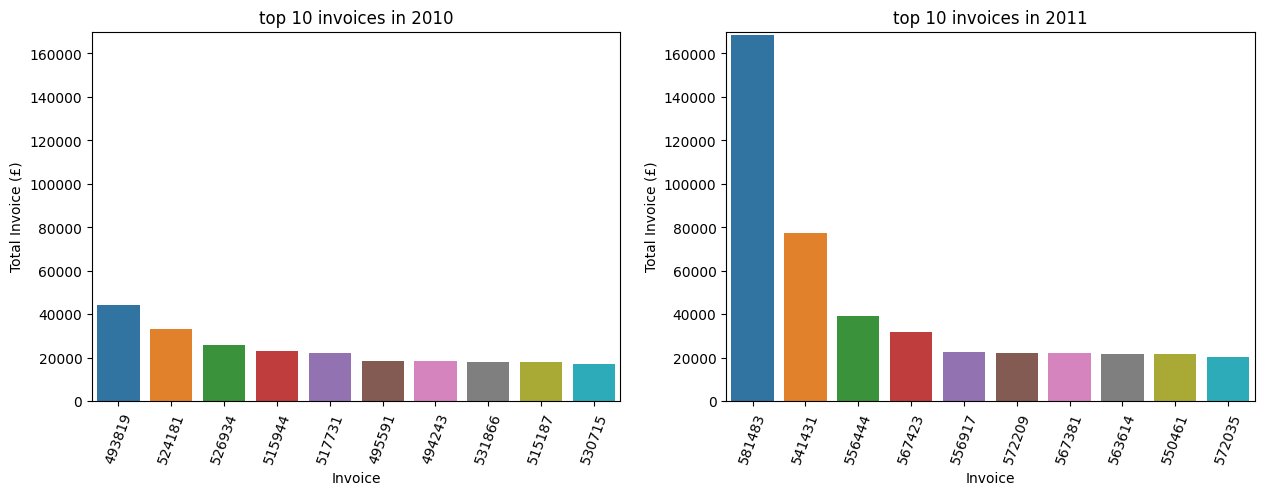

In [0]:
top_invopd_10 = top_invoices_10.sort("Total_invoice",ascending=False).limit(10).toPandas()
top_invopd_11 = top_invoices_11.sort("Total_invoice",ascending=False).limit(10).toPandas()

fig, ax =plt.subplots(1,2)
a = sns.barplot(x='Invoice',y="Total_invoice",data=top_invopd_10,ax=ax[0]).set(title="top 10 invoices in 2010",ylabel='Total Invoice (£)',ylim=(0, 170000))
q = sns.barplot(x='Invoice',y="Total_invoice",data=top_invopd_11,ax=ax[1]).set(title="top 10 invoices in 2011",ylabel='Total Invoice (£)',ylim=(0, 170000))

ax[0].tick_params(axis='x', rotation=70)
ax[1].tick_params(axis='x', rotation=70)

fig.set_figwidth(15)

### 3. Finding the top customers by volume of sales

In [0]:
#3. Top customers according to total sales by year

top_customer_10 = df10.groupBy("Customer ID", "Country") \
    .agg(round(_sum("Quantity"),2).alias("Total_Quantity"), round(_sum("Total_invoice"),2).alias("Total_Sale")) \
    .sort("Total_Sale",ascending=False).na.drop().limit(10)


top_customer_11 = df11.groupBy("Customer ID", "Country") \
    .agg(round(_sum("Quantity"),2).alias("Total_Quantity"), round(_sum("Total_invoice"),2).alias("Total_Sale")) \
    .sort("Total_Sale",ascending=False).na.drop().limit(10)

top_customer_10.sort("Total_Sale",ascending=False).limit(10).display()
top_customer_11.sort("Total_Sale",ascending=False).limit(10).display()




Customer ID Country Total_Quantity Total_Sale 18102.0 United Kingdom 124216 349164.35 14646.0 Netherlands 170278 248396.5 14156.0 EIRE 108107 196566.74 14911.0 EIRE 69722 152147.57 13694.0 United Kingdom 125893 131443.19 17511.0 United Kingdom 55107 84541.17 15061.0 United Kingdom 51791 83284.38 16684.0 United Kingdom 54555 80489.21 16754.0 United Kingdom 63551 65500.07 17949.0 United Kingdom 30112 60117.6

Customer ID Country Total_Quantity Total_Sale 14646.0 Netherlands 196915 280206.02 18102.0 United Kingdom 64124 259657.3 17450.0 United Kingdom 69993 194550.79 16446.0 United Kingdom 80997 168472.5 14911.0 EIRE 80265 143825.06 12415.0 Australia 77374 124914.53 14156.0 EIRE 57885 117379.63 17511.0 United Kingdom 64549 91062.38 16029.0 United Kingdom 40208 81024.84 12346.0 United Kingdom 74215 77183.6

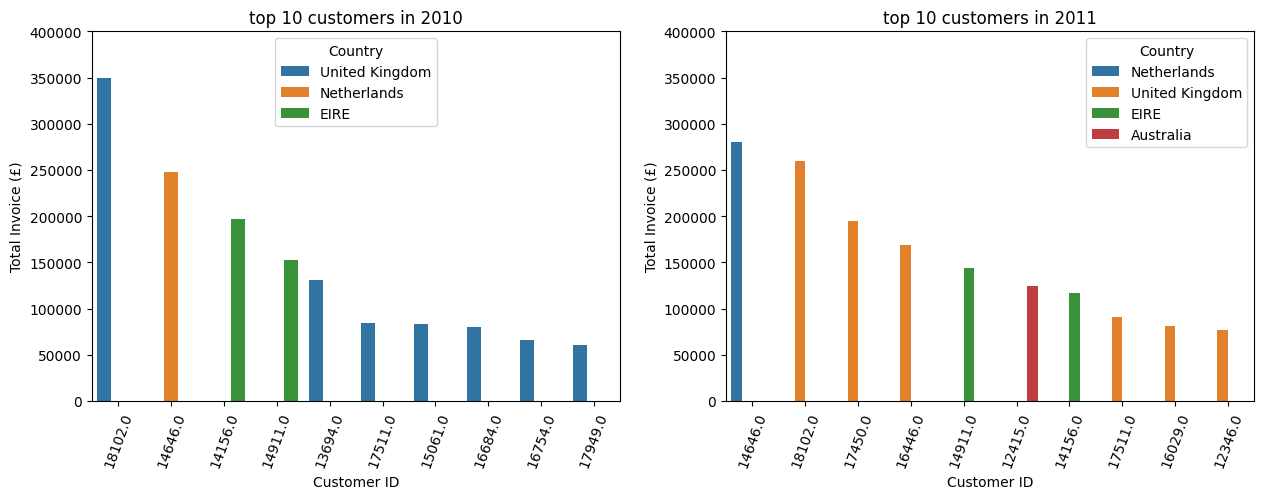

In [0]:
top_customer_10pd = top_customer_10.sort("Total_Sale",ascending=False).limit(10).toPandas()
top_customer_11pd = top_customer_11.sort("Total_Sale",ascending=False).limit(10).toPandas()

fig, ax =plt.subplots(1,2)
a = sns.barplot(x='Customer ID',y="Total_Sale",data=top_customer_10pd,ax=ax[0],hue='Country') \
    .set(title="top 10 customers in 2010",ylabel='Total Invoice (£)',ylim=(0, 400000))

q = sns.barplot(x='Customer ID',y="Total_Sale",data=top_customer_11pd,ax=ax[1],hue='Country') \
    .set(title="top 10 customers in 2011",ylabel='Total Invoice (£)',ylim=(0, 400000))

ax[0].tick_params(axis='x', rotation=70)
ax[1].tick_params(axis='x', rotation=70)

fig.set_figwidth(15)


in terms of total sales, top customers come from UK, Netherlands, Ireland aswell as Australia.

### 4. top countries by year in term of sales excluding United Kingdom

In [0]:
#4. top countries by year in term of sales excluding United Kingdom

top_Country_10 = df10.filter("Country != 'United Kingdom'").groupBy("Country") \
    .agg(round(_sum("Quantity"),2).alias("Total_Quantity_2010"), round(_sum("Total_invoice"),2).alias("Total_Sale_2010")) \
    .sort("Total_Sale_2010",ascending=False)


top_Country_11 = df11.filter("Country != 'United Kingdom'").groupBy("Country") \
    .agg(round(_sum("Quantity"),2).alias("Total_Quantity_2011"), round(_sum("Total_invoice"),2).alias("Total_Sale_2011")) \
    .sort("Total_Sale_2011",ascending=False)

top_Country_10.replace("EIRE","Ireland").display()
top_Country_11.replace("EIRE","Ireland").display()

Country Total_Quantity_2010 Total_Sale_2010 Ireland 193116 380977.82 Netherlands 183616 268786.0 Germany 108722 202395.32 France 163183 147211.49 Sweden 52567 53525.39 Denmark 229690 50906.85 Spain 22856 47601.42 Switzerland 22255 43921.39 Australia 20189 31446.8 Belgium 12065 24557.08 Channel Islands 11991 24546.32 Portugal 12151 24269.55 Norway 7867 23944.18 Italy 7389 15067.18 Greece 6167 14335.67 Austria 6697 13414.33 Cyprus 4625 11389.75 Japan 7311 9722.02 United Arab Emirates 6339 9195.35 Hong Kong 2308 8202.52 Finland 3671 7379.46 Unspecified 3434 6186.22 Malta 1549 5373.5 Lithuania 2306 4892.68 USA 2806 4786.47 Singapore 1753 4037.77 RSA 1619 3802.01 Poland 2144 3567.8 Israel 1132 3199.4 Thailand 2552 3070.54 Bahrain 1025 2355.65 Iceland 828 1323.32 Bermuda 2798 1253.14 Canada 894 1216.66 Korea 700 1118.51 West Indies 395 536.41 Brazil 189 268.27 Lebanon 72 211.7 Nigeria 103 140.39

Databricks visualization. Run in Databricks to view.

Country Total_Quantity_2011 Total_Sale_2011 Netherlands 200361 285446.34 Ireland 147173 283453.96 Germany 119261 228867.14 France 112104 209733.11 Australia 83901 138521.31 Spain 27940 61577.11 Switzerland 30629 57089.9 Belgium 23237 41196.34 Sweden 36083 38378.33 Japan 26016 37416.37 Norway 19336 36165.44 Portugal 16258 33747.1 Finland 10704 22546.08 Singapore 5241 21279.29 Channel Islands 9491 20450.44 Denmark 8235 18955.34 Italy 8112 17483.24 Hong Kong 4773 15691.8 Cyprus 6361 13590.38 Austria 4881 10198.68 Israel 4409 8135.26 Poland 3684 7334.65 Greece 1557 4760.52 Unspecified 3300 4749.79 Iceland 2458 4310.0 Canada 2763 3666.38 USA 2458 3580.39 Malta 970 2725.59 United Arab Emirates 982 1902.28 Lebanon 386 1693.88 Lithuania 652 1661.06 European Community 499 1300.25 Brazil 356 1143.6 RSA 351 1002.31 Czech Republic 671 826.74 Bahrain 314 754.14 Saudi Arabia 80 145.92

Databricks visualization. Run in Databricks to view.

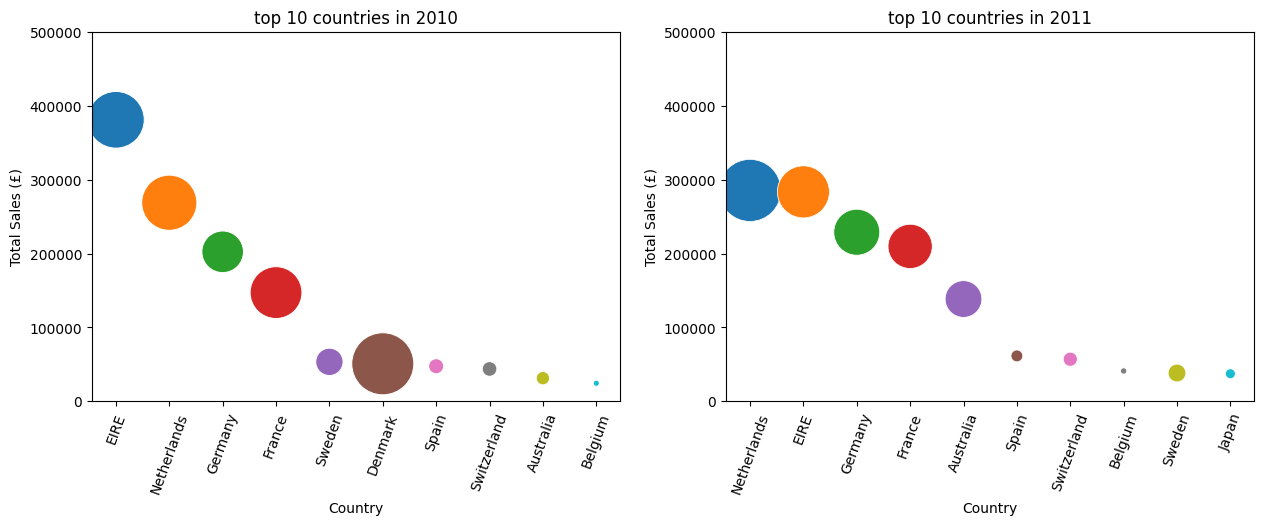

In [0]:


top_Country_10pd = top_Country_10.sort("Total_Sale_2010",ascending=False).limit(10).toPandas()

top_Country_11pd = top_Country_11.sort("Total_Sale_2011",ascending=False).limit(10).toPandas()

fig, ax =plt.subplots(1,2)

sns.scatterplot(data=top_Country_10pd,ax=ax[0], x="Country", y="Total_Sale_2010", size="Total_Quantity_2010", legend=False, sizes=(20, 2000), hue='Country') \
    .set(title="top 10 countries in 2010",ylabel='Total Sales (£)',ylim=(0, 500000))

sns.scatterplot(data=top_Country_11pd,ax=ax[1], x="Country", y="Total_Sale_2011", size="Total_Quantity_2011", legend=False, sizes=(20, 2000), hue='Country') \
    .set(title="top 10 countries in 2011",ylabel='Total Sales (£)',ylim=(0, 500000))
#a = sns.barplot(x='Customer ID',y="Total_Sale",data=top_customer_10pd,ax=ax[0],hue='Country') \
   

#q = sns.barplot(x='Customer ID',y="Total_Sale",data=top_customer_11pd,ax=ax[1],hue='Country') \
    #.set(title="top 10 customers in 2011",ylabel='Total Invoice (£)',ylim=(0, 400000))

ax[0].tick_params(axis='x', rotation=70)
ax[1].tick_params(axis='x', rotation=70)

fig.set_figwidth(15)

### 5. Most growing nation sale-wise

In [0]:
#5. Most growing nation sale-wise
def percentage_sale(a,b):
    return ((b-a)/a)*100
    
percentage_sale_udf = udf(percentage_sale,DoubleType())

#TODO add udf

df_sale_per = top_Country_10.join(top_Country_11, on="Country").select("Country","Total_Sale_2010","Total_Sale_2011")
df_sale_per = df_sale_per.withColumn('Percentage_change', round((percentage_sale(df_sale_per['Total_Sale_2010'], df_sale_per['Total_Sale_2011'])),2)).sort("Percentage_change", ascending = False)
#df_sale_per = df_sale_per.withColumn('percentage_change', (percentage_sale_udf(df_sale_per['Total_Sale_2010'], df_sale_per['Total_Sale_2011'])))

df_sale_per.display()

Country Total_Sale_2010 Total_Sale_2011 Percentage_change Lebanon 211.7 1693.88 700.13 Singapore 4037.77 21279.29 427.01 Australia 31446.8 138521.31 340.49 Brazil 268.27 1143.6 326.29 Japan 9722.02 37416.37 284.86 Iceland 1323.32 4310.0 225.7 Finland 7379.46 22546.08 205.52 Canada 1216.66 3666.38 201.35 Israel 3199.4 8135.26 154.27 Poland 3567.8 7334.65 105.58 Hong Kong 8202.52 15691.8 91.3 Belgium 24557.08 41196.34 67.76 Norway 23944.18 36165.44 51.04 France 147211.49 209733.11 42.47 Portugal 24269.55 33747.1 39.05 Switzerland 43921.39 57089.9 29.98 Spain 47601.42 61577.11 29.36 Cyprus 11389.75 13590.38 19.32 Italy 15067.18 17483.24 16.04 Germany 202395.32 228867.14 13.08 Netherlands 268786.0 285446.34 6.2 Channel Islands 24546.32 20450.44 -16.69 Unspecified 6186.22 4749.79 -23.22 Austria 13414.33 10198.68 -23.97 USA 4786.47 3580.39 -25.2 EIRE 380977.82 283453.96 -25.6 Sweden 53525.39 38378.33 -28.3 Malta 5373.5 2725.59 -49.28 Denmark 50906.85 18955.34 -62.76 Lithuania 4892.68 1661.06 -66.05 Greece 14335.67 4760.52 -66.79 Bahrain 2355.65 754.14 -67.99 RSA 3802.01 1002.31 -73.64 United Arab Emirates 9195.35 1902.28 -79.31

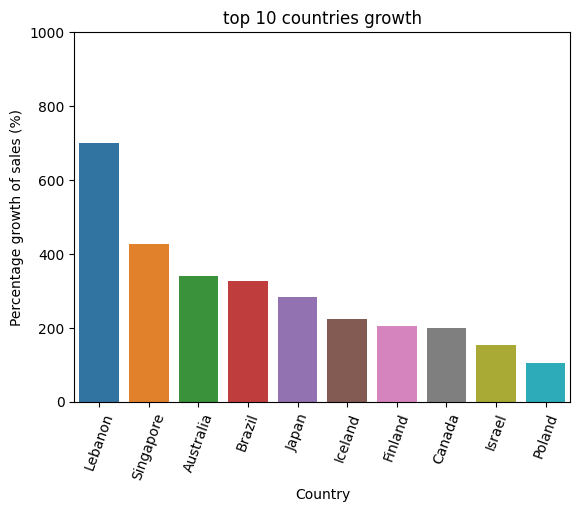

In [0]:
sale_per = df_sale_per.limit(10).toPandas()
fig,ax = fig, ax =plt.subplots(1,1)
sns.barplot(x='Country',y="Percentage_change",data=sale_per,ax=ax) \
    .set(title="top 10 countries growth",ylabel='Percentage growth of sales (%)',ylim=(0, 1000))
    
ax.tick_params(axis='x', rotation=70)


Surprisingly countries with hight growth in terms of sales show a big increase, specially Australia which was one of the top contries in sales for 2010 showed an increase of 340% in 2011

### 6. Non-UK countries by month to focus on particular sales in that area in that time

In [0]:
#6. Non-UK countries by month to focus on particular sales in that area in that time

sales_month_10 = df10.filter("Country !='United Kingdom'").filter("Year !=2009").filter("Month !=12") \
    .groupBy("Country","Year","Month") \
    .agg(round(_sum("Total_Invoice"),2).alias("Total")) \
    .sort("Country","Year","Month")

sales_month_11 = df11.filter("Country !='United Kingdom'").filter("Year !=2010").filter("Month !=12") \
    .groupBy("Country","Year","Month") \
    .agg(round(_sum("Total_Invoice"),2) \
    .alias("Total"))\
    .sort("Country","Year","Month")

sales_month_10.display()
sales_month_11.display()


Country Year Month Total Australia 2010 2 1029.66 Australia 2010 3 429.39 Australia 2010 4 630.95 Australia 2010 5 2371.15 Australia 2010 6 3214.78 Australia 2010 7 686.12 Australia 2010 8 176.0 Australia 2010 9 785.83 Australia 2010 10 2989.15 Australia 2010 11 18245.52 Austria 2010 2 1118.86 Austria 2010 3 925.13 Austria 2010 4 1388.54 Austria 2010 5 622.04 Austria 2010 6 268.1 Austria 2010 8 1043.15 Austria 2010 9 1940.17 Austria 2010 10 1236.7 Austria 2010 11 2873.3 Bahrain 2010 2 439.85 Bahrain 2010 3 548.8 Bahrain 2010 5 585.96 Bahrain 2010 6 463.28 Bahrain 2010 10 317.76 Belgium 2010 1 1634.02 Belgium 2010 2 3209.0 Belgium 2010 3 904.02 Belgium 2010 4 2570.39 Belgium 2010 5 98.15 Belgium 2010 6 3800.34 Belgium 2010 7 1914.23 Belgium 2010 8 1713.62 Belgium 2010 9 1190.91 Belgium 2010 10 1475.72 Belgium 2010 11 5252.98 Bermuda 2010 3 1253.14 Brazil 2010 9 268.27 Canada 2010 10 834.89 Canada 2010 11 381.77 Channel Islands 2010 1 838.75 Channel Islands 2010 3 1065.12 Channel Islands 2010 4 926.82 Channel Islands 2010 5 5378.52 Channel Islands 2010 6 845.0 Channel Islands 2010 8 1363.14 Channel Islands 2010 9 6156.34 Channel Islands 2010 10 4341.19 Channel Islands 2010 11 2278.73 Cyprus 2010 1 76.52 Cyprus 2010 2 750.49 Cyprus 2010 3 2879.19 Cyprus 2010 4 1151.7 Cyprus 2010 5 515.61 Cyprus 2010 6 489.8 Cyprus 2010 9 1020.53 Cyprus 2010 10 551.33 Cyprus 2010 11 397.6 Denmark 2010 1 7870.6 Denmark 2010 2 19809.9 Denmark 2010 3 7595.18 Denmark 2010 4 748.0 Denmark 2010 6 2695.51 Denmark 2010 7 591.66 Denmark 2010 8 2643.03 Denmark 2010 9 1725.25 Denmark 2010 10 448.6 Denmark 2010 11 4059.96 EIRE 2010 1 65258.43 EIRE 2010 2 21538.8 EIRE 2010 3 22989.46 EIRE 2010 4 23929.48 EIRE 2010 5 19121.93 EIRE 2010 6 22934.34 EIRE 2010 7 35722.32 EIRE 2010 8 26005.71 EIRE 2010 9 36984.47 EIRE 2010 10 50079.05 EIRE 2010 11 31031.31 Finland 2010 1 801.42 Finland 2010 4 1255.13 Finland 2010 5 837.11 Finland 2010 6 534.14 Finland 2010 7 956.23 Finland 2010 9 864.68 Finland 2010 10 1166.69 Finland 2010 11 414.98 France 2010 1 8465.63 France 2010 2 9024.16 France 2010 3 8657.59 France 2010 4 7642.98 France 2010 5 13958.15 France 2010 6 9172.54 France 2010 7 11546.64 France 2010 8 16570.32 France 2010 9 14531.33 France 2010 10 15211.77 France 2010 11 19618.27 Germany 2010 1 12562.11 Germany 2010 2 9124.25 Germany 2010 3 16698.08 Germany 2010 4 23683.23 Germany 2010 5 9108.36 Germany 2010 6 15678.63 Germany 2010 7 20274.29 Germany 2010 8 9943.12 Germany 2010 9 17740.18 Germany 2010 10 21561.63 Germany 2010 11 30240.51 Greece 2010 1 4798.35 Greece 2010 3 522.73 Greece 2010 4 277.93 Greece 2010 5 2476.22 Greece 2010 6 302.4 Greece 2010 8 721.71 Greece 2010 9 780.06 Greece 2010 10 3084.02 Greece 2010 11 761.3 Hong Kong 2010 4 2236.61 Hong Kong 2010 5 2396.61 Hong Kong 2010 6 1685.65 Hong Kong 2010 8 1883.65 Iceland 2010 10 611.53 Israel 2010 7 1950.98 Israel 2010 11 1248.42 Italy 2010 1 39.67 Italy 2010 3 734.22 Italy 2010 4 1525.85 Italy 2010 5 2374.7 Italy 2010 6 267.45 Italy 2010 9 1380.56 Italy 2010 10 5221.42 Italy 2010 11 2673.16 Japan 2010 1 2.95 Japan 2010 2 193.72 Japan 2010 3 110.4 Japan 2010 6 594.68 Japan 2010 7 1253.3 Japan 2010 9 1895.0 Japan 2010 10 1533.89 Japan 2010 11 23.6 Korea 2010 9 168.69 Korea 2010 11 949.82 Lebanon 2010 9 211.7 Lithuania 2010 7 1706.23 Lithuania 2010 11 1525.39 Malta 2010 2 1636.38 Malta 2010 8 3737.12 Netherlands 2010 1 29230.77 Netherlands 2010 2 17255.39 Netherlands 2010 3 24447.98 Netherlands 2010 4 6888.78 Netherlands 2010 5 22416.53 Netherlands 2010 6 24224.51 Netherlands 2010 7 5534.29 Netherlands 2010 8 25028.69 Netherlands 2010 9 45037.14 Netherlands 2010 10 17265.85 Netherlands 2010 11 36058.74 Nigeria 2010 1 27.82 Nigeria 2010 8 112.57 Norway 2010 3 13916.34 Norway 2010 8 152.4 Norway 2010 9 973.69 Norway 2010 11 4629.32 Poland 2010 3 318.86 Poland 2010 6 556.16 Poland 2010 7 374.75 Poland 2010 8 527.44 Poland 2010 9 349.47 Poland 2010 11 821.14 Portugal 2010 1 117.72 Portugal 2010 2 458.83 Portugal 

Country Year Month Total Australia 2011 1 9017.71 Australia 2011 2 14695.42 Australia 2011 3 17223.99 Australia 2011 4 771.6 Australia 2011 5 13638.41 Australia 2011 6 25187.77 Australia 2011 7 4964.38 Australia 2011 8 22489.2 Australia 2011 9 5106.73 Australia 2011 10 17150.53 Australia 2011 11 7242.72 Austria 2011 2 518.36 Austria 2011 3 1708.12 Austria 2011 4 680.78 Austria 2011 5 1249.43 Austria 2011 7 1191.95 Austria 2011 8 1516.08 Austria 2011 10 1043.78 Austria 2011 11 1329.78 Bahrain 2011 5 548.4 Belgium 2011 1 1200.2 Belgium 2011 2 2181.07 Belgium 2011 3 3351.98 Belgium 2011 4 1989.48 Belgium 2011 5 2732.4 Belgium 2011 6 4274.82 Belgium 2011 7 2475.57 Belgium 2011 8 3554.02 Belgium 2011 9 4208.02 Belgium 2011 10 5685.38 Belgium 2011 11 6315.76 Brazil 2011 4 1143.6 Canada 2011 3 140.54 Canada 2011 5 534.24 Canada 2011 6 1171.46 Canada 2011 7 1768.58 Canada 2011 8 51.56 Channel Islands 2011 1 675.58 Channel Islands 2011 2 1784.71 Channel Islands 2011 3 3509.33 Channel Islands 2011 4 293.0 Channel Islands 2011 5 1207.24 Channel Islands 2011 6 2060.03 Channel Islands 2011 8 4896.78 Channel Islands 2011 9 1323.75 Channel Islands 2011 10 2623.32 Channel Islands 2011 11 1514.77 Cyprus 2011 1 547.5 Cyprus 2011 2 4334.24 Cyprus 2011 3 938.39 Cyprus 2011 6 1109.32 Cyprus 2011 9 196.35 Cyprus 2011 10 4412.87 Cyprus 2011 11 460.89 Czech Republic 2011 2 549.26 Czech Republic 2011 10 277.48 Denmark 2011 2 399.22 Denmark 2011 3 3978.99 Denmark 2011 5 515.7 Denmark 2011 6 3261.15 Denmark 2011 7 376.24 Denmark 2011 8 213.15 Denmark 2011 9 4570.16 Denmark 2011 10 1490.76 Denmark 2011 11 2699.57 EIRE 2011 1 21904.19 EIRE 2011 2 12248.74 EIRE 2011 3 22197.51 EIRE 2011 4 7570.5 EIRE 2011 5 18008.76 EIRE 2011 6 24863.61 EIRE 2011 7 42789.85 EIRE 2011 8 18353.75 EIRE 2011 9 43086.55 EIRE 2011 10 24317.92 EIRE 2011 11 30738.43 European Community 2011 4 191.4 European Community 2011 6 432.05 European Community 2011 7 676.8 Finland 2011 1 889.02 Finland 2011 2 205.16 Finland 2011 3 5936.82 Finland 2011 4 1688.92 Finland 2011 6 329.56 Finland 2011 7 2996.73 Finland 2011 8 1376.5 Finland 2011 9 1105.45 Finland 2011 10 2822.12 Finland 2011 11 3070.24 France 2011 1 17740.12 France 2011 2 8515.96 France 2011 3 14589.55 France 2011 4 5529.61 France 2011 5 17614.88 France 2011 6 16348.41 France 2011 7 10000.19 France 2011 8 13810.96 France 2011 9 23428.04 France 2011 10 33485.45 France 2011 11 31758.71 Germany 2011 1 16910.84 Germany 2011 2 9581.05 Germany 2011 3 14392.69 Germany 2011 4 12315.54 Germany 2011 5 25751.2 Germany 2011 6 13274.1 Germany 2011 7 16440.98 Germany 2011 8 19220.77 Germany 2011 9 18091.22 Germany 2011 10 31638.42 Germany 2011 11 28025.02 Greece 2011 1 2661.24 Greece 2011 3 387.31 Greece 2011 4 609.74 Greece 2011 7 421.24 Hong Kong 2011 1 2439.76 Hong Kong 2011 3 2583.76 Hong Kong 2011 4 1539.64 Hong Kong 2011 5 1966.16 Hong Kong 2011 6 633.96 Hong Kong 2011 8 2813.95 Hong Kong 2011 9 2653.95 Hong Kong 2011 10 734.52 Hong Kong 2011 11 326.1 Iceland 2011 1 475.39 Iceland 2011 4 636.25 Iceland 2011 6 382.52 Iceland 2011 8 584.91 Iceland 2011 10 1294.32 Israel 2011 1 379.84 Israel 2011 2 779.1 Israel 2011 4 110.0 Israel 2011 7 1430.75 Israel 2011 8 4873.81 Israel 2011 9 423.73 Israel 2011 10 138.03 Italy 2011 1 2402.51 Italy 2011 2 256.0 Italy 2011 3 1806.81 Italy 2011 4 737.83 Italy 2011 5 587.45 Italy 2011 6 202.07 Italy 2011 7 147.1 Italy 2011 8 1990.95 Italy 2011 9 279.8 Italy 2011 10 3489.69 Italy 2011 11 4571.08 Japan 2011 2 5780.81 Japan 2011 3 48.9 Japan 2011 4 6548.5 Japan 2011 5 1351.45 Japan 2011 6 1607.04 Japan 2011 7 3854.4 Japan 2011 9 112.08 Japan 2011 10 1948.04 Japan 2011 11 8460.08 Lebanon 2011 1 1693.88 Malta 2011 6 863.16 Malta 2011 8 1119.0 Malta 2011 11 743.43 Netherlands 2011 1 26611.16 Netherlands 2011 2 23011.91 Netherlands 2011 3 22416.49 Netherlands 2011 4 2976.56 Netherlands 2011 5 29185.88 Netherlands 2011 6 26858.09 Netherlands 2011 7 26.02 Netherlands 2011 8 40327.81 Netherlands 2011 9 26937.26 Nether

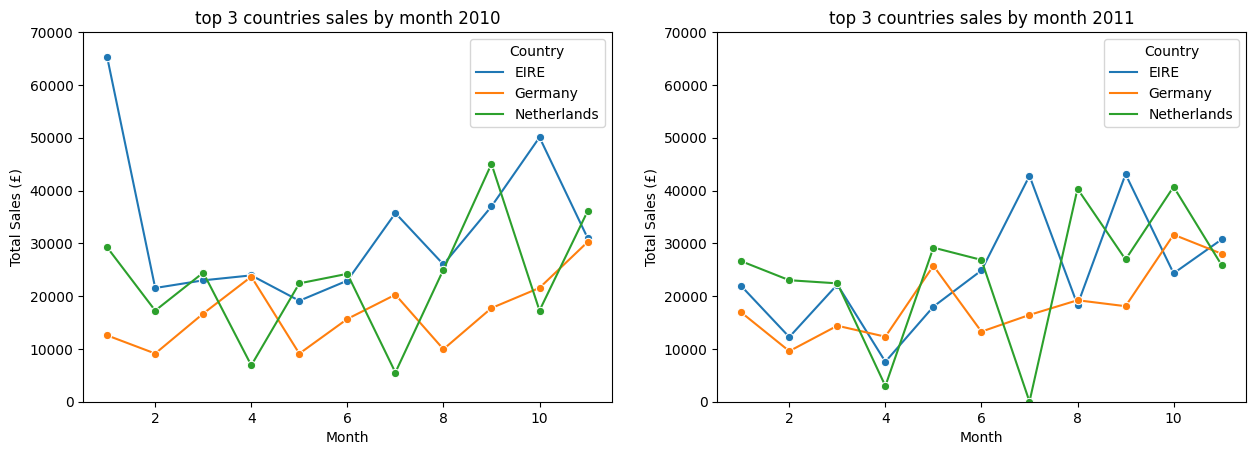

In [0]:

top_Country_10pd = top_Country_10.sort("Total_Sale_2010",ascending=False).limit(3).toPandas()
top_c10_list = top_Country_10pd['Country'].tolist()
sales_month_10pd = sales_month_10.filter(sales_month_10.Country.isin(top_c10_list)).toPandas()

top_Country_11pd = top_Country_11.sort("Total_Sale_2011",ascending=False).limit(3).toPandas()
top_c11_list = top_Country_11pd['Country'].tolist()
sales_month_11pd = sales_month_11.filter(sales_month_11.Country.isin(top_c11_list)).toPandas()

fig, ax =plt.subplots(1,2)

sns.lineplot(x='Month', y='Total', hue='Country', data=sales_month_10pd,ax=ax[0],marker="o") \
    .set(title="top 3 countries sales by month 2010",ylabel='Total Sales (£)',ylim=(0, 70000))

sns.lineplot(x='Month', y='Total', hue='Country', data=sales_month_11pd,ax=ax[1],marker="o") \
    .set(title="top 3 countries sales by month 2011",ylabel='Total Sales (£)',ylim=(0, 70000))
fig.set_figwidth(15)

The top 3 non UK contries are Ireland, Germany and the Netherlands for both of the two periods explored, with a similar purchasing behaviour.

### 7. Top Customers excluding United Kingdom and orders with null Customer ID

A big part of the sales are not linked to a specific customer, it would be necessary to fix it in the future to accurataly understand key customers to push loyalty programs, in the following analysis orders not associated with a customers were disregarded. top customers are based mainly in Europe with the exception of one located in Australia.

In [0]:
#7. Top Customers excluding United Kingdom and orders with null Customer ID

# top customers by country and total sale by year

def Total_customer(df):

    # Top customers by country and total sales
    TotalCustomer = df.filter("Country !='United Kingdom'") \
    .groupBy("Customer ID", "Country") \
    .agg(round(_sum("Total_invoice"),2).alias("Total_Sale")) \
    .sort("Total_Sale",ascending=False).na.drop()

    # Total sales in specific year
    total_sum = TotalCustomer.select("Total_Sale") \
            .agg(_sum("Total_Sale").alias("sumt")) \
            .collect().pop()['sumt']
    
    # Calculate percentage of the total by customer
    TotalCustomerF= TotalCustomer.withColumn('percent', round((TotalCustomer['Total_Sale']/total_sum) * 100,2))

    return TotalCustomerF


TotalCustomer10 = Total_customer(df10)
TotalCustomer11 = Total_customer(df11)

print("Top 10 customers in 2010 (non UK customers)")
TotalCustomer10.limit(10).display()



Top 10 customers in 2010 (non UK customers)


Customer ID Country Total_Sale percent 14646.0 Netherlands 248396.5 17.53 14156.0 EIRE 196566.74 13.87 14911.0 EIRE 152147.57 10.74 13902.0 Denmark 34095.26 2.41 12482.0 Sweden 23691.4 1.67 12709.0 Germany 21356.82 1.51 12471.0 Germany 20139.74 1.42 12415.0 Australia 19543.84 1.38 12681.0 France 17080.74 1.21 12678.0 France 16652.72 1.18

Databricks visualization. Run in Databricks to view.

In [0]:
print("Top 10 customers in 2011 (non UK customers)")
TotalCustomer11.limit(10).display()

Top 10 customers in 2011 (non UK customers)


Customer ID Country Total_Sale percent 14646.0 Netherlands 280206.02 17.48 14911.0 EIRE 143825.06 8.97 12415.0 Australia 124914.53 7.79 14156.0 EIRE 117379.63 7.32 17404.0 Sweden 31906.82 1.99 12753.0 Japan 21429.39 1.34 12744.0 Singapore 21279.29 1.33 12471.0 Germany 19824.05 1.24 12731.0 France 18895.91 1.18 12678.0 France 17628.46 1.1

Databricks visualization. Run in Databricks to view.

### 8. Most ordered Product sales by month for top 3 countries

In [0]:
#8. Most ordered Product sales by month for top 3 countries

#top3_09 = top_Country_09.select("Country").limit(3).rdd.map(lambda x: x[3]).collect()
top_country_10l = ["EIRE", "Netherlands", "Germany"]
top_country_11l = ["Netherlands", "EIRE", "Germany"]

from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

def top_prod(df,country):
    
    top_prod = df.filter(f"Country == '{country}'") \
        .groupBy("Year", "Month", "StockCode", "Description","Price") \
        .agg(round(_sum("Quantity"),2).alias("Total_Quantity"))
    
    w = Window.partitionBy("Year","Month").orderBy(col("Total_Quantity").desc())

    top_prod.withColumn("row",row_number().over(w)).filter(col("row") == 1).drop("row").display()

for country in top_country_10l:
    print(country+" 2010\n")
    top_prod(df10,country)

for country in top_country_11l:
    print(country+" 2011\n")
    top_prod(df11,country)


EIRE 2010



Year Month StockCode Description Price Total_Quantity 2009 12 21181 PLEASE ONE PERSON METAL SIGN 1.85 288 2010 1 37340 MULTICOLOUR SPRING FLOWER MUG 0.64 624 2010 2 21169 YOU'RE CONFUSING ME METAL SIGN 1.45 384 2010 3 17084R ASSORTED INCENSE PACK 0.16 1440 2010 4 17039 INLAID WOOD INCENSE HOLDER 0.21 500 2010 5 71459 HANGING JAM JAR T-LIGHT HOLDER 0.72 672 2010 6 22197 SMALL POPCORN HOLDER 0.72 400 2010 7 20914 SET/5 RED SPOTTY LID GLASS BOWLS 2.55 608 2010 8 22197 SMALL POPCORN HOLDER 0.72 600 2010 9 22950 36 DOILIES VINTAGE CHRISTMAS 1.25 576 2010 10 16033 MINI HIGHLIGHTER PENS 0.12 240 2010 11 22740 POLKADOT PEN 0.85 240 2010 12 17084R ASSORTED INCENSE PACK 0.16 1440

Netherlands 2010



Year Month StockCode Description Price Total_Quantity 2009 12 85123A WHITE HANGING HEART T-LIGHT HOLDER 2.55 480 2010 1 21121 SET/10 RED SPOTTY PARTY CANDLES 1.06 576 2010 2 21731 RED TOADSTOOL LED NIGHT LIGHT 1.45 720 2010 3 35961 FOLKART ZINC HEART CHRISTMAS DEC 0.72 1152 2010 4 22094 RED POLKA DOT TISSUE BOX 1.06 504 2010 5 22492 MINI PAINT SET VINTAGE BOY+ GIRL 0.55 576 2010 6 20712 JUMBO BAG WOODLAND ANIMALS 1.65 500 2010 7 22489 PACK OF 12 TRADITIONAL CRAYONS 0.36 288 2010 8 35961 FOLKART ZINC HEART CHRISTMAS DEC 0.72 576 2010 9 35961 FOLKART ZINC HEART CHRISTMAS DEC 0.72 1152 2010 10 35961 FOLKART ZINC HEART CHRISTMAS DEC 0.72 864 2010 11 22630 DOLLY GIRL LUNCH BOX 1.65 960 2010 12 22867 HAND WARMER BIRD DESIGN 1.85 96

Germany 2010



Year Month StockCode Description Price Total_Quantity 2009 12 84568 GIRLS ALPHABET IRON ON PATCHES 0.21 288 2010 1 22333 RETRO SPORT PARTY BAG + STICKER SET 1.45 144 2010 2 84568 GIRLS ALPHABET IRON ON PATCHES 0.21 288 2010 3 21981 PACK OF 12 WOODLAND TISSUES 0.25 432 2010 4 21878 PACK OF 6 SANDCASTLE FLAGS ASSORTED 0.72 200 2010 5 15036 ASSORTED COLOURS SILK FAN 0.75 240 2010 6 85162B BLACK RETRODISC LAMPSHADE 1.95 293 2010 7 15036 ASSORTED COLOURS SILK FAN 0.65 600 2010 8 84598 BOYS ALPHABET IRON ON PATCHES 0.21 288 2010 9 84568 GIRLS ALPHABET IRON ON PATCHES 0.21 288 2010 10 20973 12 PENCIL SMALL TUBE WOODLAND 0.55 384 2010 11 20760 GARDEN PATH POCKET BOOK 0.64 480 2010 12 22326 ROUND SNACK BOXES SET OF4 WOODLAND 2.95 66

Netherlands 2011



Year Month StockCode Description Price Total_Quantity 2010 12 22378 WALL TIDY RETROSPOT 0.85 300 2011 1 21212 PACK OF 72 RETROSPOT CAKE CASES 0.42 1680 2011 2 22630 DOLLY GIRL LUNCH BOX 1.65 448 2011 3 22630 DOLLY GIRL LUNCH BOX 1.65 640 2011 4 85099B JUMBO BAG RED RETROSPOT 1.65 200 2011 5 21212 PACK OF 72 RETROSPOT CAKE CASES 0.42 1200 2011 6 22326 ROUND SNACK BOXES SET OF4 WOODLAND 2.55 528 2011 7 23294 SET OF 6 SNACK LOAF BAKING CASES 0.83 1 2011 8 22629 SPACEBOY LUNCH BOX 1.65 896 2011 9 23345 DOLLY GIRL BEAKER 1.08 400 2011 10 23084 RABBIT NIGHT LIGHT 2.08 2400 2011 11 22492 MINI PAINT SET VINTAGE 0.55 1152 2011 12 23084 RABBIT NIGHT LIGHT 1.79 1440

EIRE 2011



Year Month StockCode Description Price Total_Quantity 2010 12 17084R ASSORTED INCENSE PACK 0.16 1440 2011 1 21292 SMALL STRIPES CHOCOLATE GIFT BAG 0.64 384 2011 2 22197 SMALL POPCORN HOLDER 0.72 400 2011 3 21975 PACK OF 60 DINOSAUR CAKE CASES 0.42 240 2011 4 21166 COOK WITH WINE METAL SIGN 1.85 144 2011 5 21212 PACK OF 72 RETROSPOT CAKE CASES 0.42 240 2011 6 21787 RAIN PONCHO RETROSPOT 0.65 288 2011 7 21212 PACK OF 72 RETROSPOT CAKE CASES 0.55 480 2011 8 22950 36 DOILIES VINTAGE CHRISTMAS 1.25 288 2011 9 84212 "ASSORTED FLOWER COLOUR ""LEIS""" 0.42 960 2011 10 22266 EASTER DECORATION HANGING BUNNY 0.19 704 2011 11 22578 WOODEN STAR CHRISTMAS SCANDINAVIAN 0.29 432 2011 12 22197 POPCORN HOLDER 0.85 96

Germany 2011



Year Month StockCode Description Price Total_Quantity 2010 12 22961 JAM MAKING SET PRINTED 1.45 144 2011 1 84692 BOX OF 24 COCKTAIL PARASOLS 0.42 150 2011 2 22585 PACK OF 6 BIRDY GIFT TAGS 1.06 288 2011 3 22585 PACK OF 6 BIRDY GIFT TAGS 1.06 288 2011 4 22893 MINI CAKE STAND T-LIGHT HOLDER 0.36 288 2011 5 15036 ASSORTED COLOURS SILK FAN 0.65 600 2011 6 15036 ASSORTED COLOURS SILK FAN 0.83 360 2011 7 23307 SET OF 60 PANTRY DESIGN CAKE CASES 0.55 144 2011 8 22741 FUNKY DIVA PEN 0.85 192 2011 9 16045 POPART WOODEN PENCILS ASST 0.04 200 2011 10 16045 POPART WOODEN PENCILS ASST 0.04 600 2011 11 84598 BOYS ALPHABET IRON ON PATCHES 0.21 288 2011 12 21232 STRAWBERRY CERAMIC TRINKET POT 1.25 84

### 9. Number of units sold by month

In [0]:
#9. Number of units sold by month

units_10 = df10.filter("Year != 2009").groupby("Year", "Month").agg(_sum("Quantity").alias("Total_Units"))
units_11 = df11.filter("Year != 2010").groupby("Year", "Month").agg(_sum("Quantity").alias("Total_Units"))

units_10.sort("Year","Month").display()


Year Month Total_Units 2010 1 391525 2010 2 382782 2010 3 527401 2010 4 368198 2010 5 397206 2010 6 408636 2010 7 338920 2010 8 473420 2010 9 585357 2010 10 622095 2010 11 728449 2010 12 180959

Databricks visualization. Run in Databricks to view.

In [0]:
units_11.sort("Year","Month").display()

Year Month Total_Units 2011 1 387785 2011 2 283555 2011 3 377526 2011 4 308815 2011 5 395738 2011 6 389213 2011 7 401759 2011 8 421770 2011 9 570820 2011 10 623401 2011 11 754507 2011 12 314249

Databricks visualization. Run in Databricks to view.